In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('cropland_fires.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

In [11]:
def prepare_data(df):
    # Convert date columns to datetime
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    
    # Filter only ch4 emissions records
    ch4_data = df[df['gas'] == 'ch4'].copy()
    
    # Create features
    ch4_data['month_num'] = ch4_data['start_time'].dt.month
    ch4_data['year'] = ch4_data['start_time'].dt.year
    
    # Select features for prediction
    features = ['capacity', 'activity', 'month_num', 'year', 'emissions_factor']
    target = 'emissions_quantity'
    
    X = ch4_data[features]
    y = ch4_data[target]
    
    return X, y

In [12]:
def train_and_evaluate_models(X, y, random_state=42):
    """
    Train and evaluate multiple regression models.
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Training data
    y : array-like of shape (n_samples,)
        Target values
    random_state : int, default=42
        Random state for reproducibility
        
    Returns:
    --------
    tuple
        (results dictionary containing model metrics, fitted scaler)
    """
    # Input validation
    if X is None or y is None:
        raise ValueError("X and y cannot be None")
    if len(X) != len(y):
        raise ValueError("X and y must have the same number of samples")
    
    try:
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, 
            test_size=0.2, 
            random_state=random_state
        )
        
        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Initialize models
        models = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(
                n_estimators=100, 
                random_state=random_state
            )
        }
        
        results = {}
        
        # Train and evaluate each model
        for name, model in models.items():
            try:
                # Train the model
                model.fit(X_train_scaled, y_train)
                
                # Make predictions
                y_pred = model.predict(X_test_scaled)
                
                # Calculate metrics
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                r2 = r2_score(y_test, y_pred)
                
                # Perform cross-validation
                cv_scores = cross_val_score(
                    model, 
                    X_train_scaled, 
                    y_train, 
                    cv=5, 
                    scoring='r2'
                )
                
                results[name] = {
                    'RMSE': rmse,
                    'R2': r2,
                    'CV_R2_mean': cv_scores.mean(),
                    'CV_R2_std': cv_scores.std(),
                    'model': model,
                    'predictions': y_pred,
                    'actual': y_test
                }
                
            except Exception as e:
                print(f"Error training {name}: {str(e)}")
                continue
                
        return results, scaler
        
    except Exception as e:
        raise Exception(f"Error in model training pipeline: {str(e)}")

In [13]:
def plot_results(results):
    plt.figure(figsize=(15, 5))
    
    # Plot actual vs predicted for both models
    for i, (name, result) in enumerate(results.items(), 1):
        plt.subplot(1, 2, i)
        plt.scatter(result['actual'], result['predictions'], alpha=0.5)
        plt.plot([min(result['actual']), max(result['actual'])], 
                [min(result['actual']), max(result['actual'])], 
                'r--', lw=2)
        plt.xlabel('Actual CH4 Emissions')
        plt.ylabel('Predicted CH4 Emissions')
        plt.title(f'{name}\nR² = {result["R2"]:.3f}')
    
    plt.tight_layout()
    return plt


Results for Linear Regression:
RMSE: 0.00
R2 Score: 1.000
Cross-validation R2 Score: 1.000 (+/- 0.000)

Results for Random Forest:
RMSE: 0.48
R2 Score: 0.999
Cross-validation R2 Score: 0.996 (+/- 0.014)


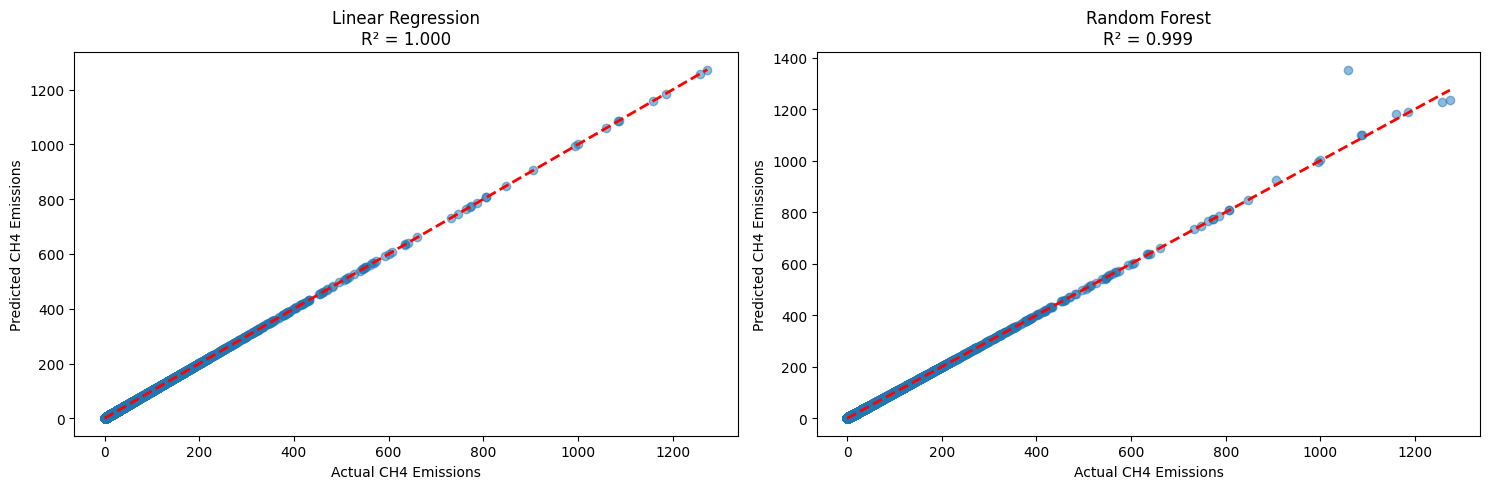


Linear Regression prediction for sample data: 6.47

Random Forest prediction for sample data: 6.47


In [14]:
X, y = prepare_data(df)
    
    # Train and evaluate models
results, scaler = train_and_evaluate_models(X, y)
    
    # Print results
for name, result in results.items():
        print(f"\nResults for {name}:")
        print(f"RMSE: {result['RMSE']:.2f}")
        print(f"R2 Score: {result['R2']:.3f}")
        print(f"Cross-validation R2 Score: {result['CV_R2_mean']:.3f} (+/- {result['CV_R2_std']*2:.3f})")
    
    # Plot results
plot_results(results)
plt.show()
    
    # Example of making a new prediction
sample_data = pd.DataFrame({
        'capacity': [74.48],
        'activity': [10],
        'month_num': [10],
        'year': [2017],
        'emissions_factor': [1440]
    })
sample_scaled = scaler.transform(sample_data)
    
for name, result in results.items():
        prediction = result['model'].predict(sample_scaled)
        print(f"\n{name} prediction for sample data: {prediction[0]:.2f}")